In [125]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import io
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
import neurodsp as ndsp
from scv_funcs import lfpca, utils

In [42]:
datafile = '/Users/rdgao/Documents/data/HumanV1LFP/CONTRASTtuning.mat'
data = io.loadmat(datafile, squeeze_me=True)
x_lfp = data['LFP']
x_mua = data['MUA']
fs = data['FsD']
t = data['TD']
trial_info = data['DETS']

In [75]:
# initialize object with fourier data
analysis_params = {'nperseg': int(fs),
                 'noverlap': 0,
                 'spg_outlierpct': 1.,
                 'max_freq':200}

inds = np.where(t>0.2)[0]
FT = []
for elec in np.unique(trial_info[:,0]):
    x_sel = x_lfp[np.where(trial_info[:,0]==elec)[0],:][:,inds]
    FT.append(np.abs(np.fft.fft(x_sel, n=int(fs), axis=1).T)**2.) # transpose to do the right thing
    f_axis = np.fft.fftfreq(int(fs), 1/fs)

P = np.stack(FT)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


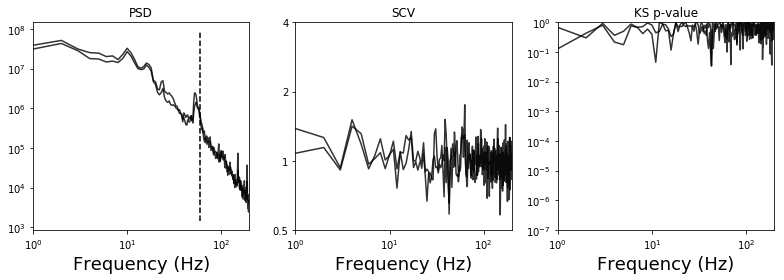

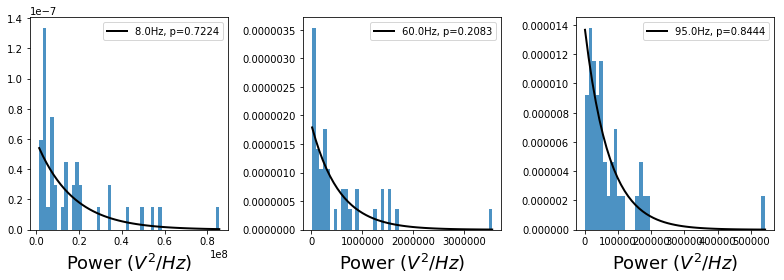

In [151]:
inds_nondup = np.concatenate([np.arange(160), np.arange(320,320+160)])
contrast = 7
P_sub = P[:,:,trial_info[inds_nondup,2]==contrast]
#P_sub=P

v1_lfpca = lfpca.LFPCA(analysis_params=analysis_params)
v1_lfpca.populate_fourier_data(P_sub, fs, f_axis[:300])
v1_lfpca.compute_KS_expfit()

plt.figure(figsize=(11,4))
v1_lfpca.plot_spectral(plot_mean=False, plot_chan=None)
plt.subplot(1,3,1)
plt.plot([60]*2,plt.ylim(), '--k')

plot_chan = 0
plot_freqs = [8,60,95]
plt.figure(figsize=(11,4))
for i,f in enumerate(plot_freqs):
    plt.subplot(1,3,i+1)
    v1_lfpca.plot_expfit(chan=plot_chan, freq_ind=f, num_bins=50)

plt.tight_layout()

### Oscillatory gamma power is stochastic??
Gamma power at 70Hz for highest contrast trials does not show up on SCV or KS test, meaning the distribution is exponential during task. Or maybe it's just underpowered?

Aggregate over all contrast, though, gamma shows significant variability.

60.011059907834095


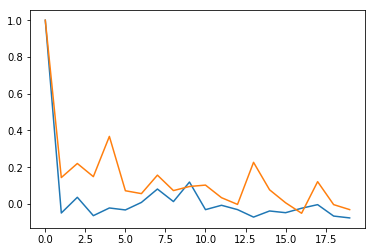

In [155]:
# check autocorrelation
chan=0
freq = 60
print(f_axis[freq])
plt.plot(utils.autocorr(P[chan,freq,:],20)[1])
plt.plot(utils.autocorr(P_sub[chan,freq,:],20)[1])